#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

Добавляем наш файлик

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: Error: credential propagation was unsuccessful

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [3]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    w = np.array(w)
    N = X.shape[0]
    linear_combination = X @ w + w0 #это получается векторное умножение и плюс смещение
    log_loss = np.sum(np.log(1 + np.exp(-y * linear_combination)))
    l1_regularization = gamma * np.sum(np.abs(w)) # обнуляем незначительные веса
    l2_regularization = beta * np.sum(w ** 2) # сглаживаем веса
    total_loss = (log_loss / N) + l1_regularization + l2_regularization
    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = X.shape[0]
    y = np.array(y)
    w = np.array(w)
    linear_combination = X @ w + w0
    grad_w = -1 / N * (X.T @ (y / (1 + np.exp(y * linear_combination)))) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -1 / N * np.sum(y / (1 + np.exp(y * linear_combination)))

    return grad_w, grad_w0



In [5]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)
print(grad_w)
print(grad_w0)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690745


####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.w0 = 0.0

        for i in range(self.max_iter):
            # Случайный индекс для SGD
            random_index = np.random.randint(0, X.shape[0])
            xi = X[random_index, :].reshape(1, -1)
            yi = y[random_index]

            grad_w, grad_w0 = get_grad(xi, yi, self.w, self.w0, self.gamma, self.beta)

            # Обновляем веса
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            # Проверка на сходимость
            if np.linalg.norm(grad_w) < self.tolerance and abs(grad_w0) < self.tolerance:
                print(f"Converged after {i} iterations")
                break

    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        linear_combination = X @ self.w + self.w0
        return (linear_combination >= 0).astype(int)

    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        linear_combination = X @ self.w + self.w0
        return 1 / (1 + np.exp(-linear_combination))


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    # сетка для графика
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')

    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary and Data Points")
    plt.show()

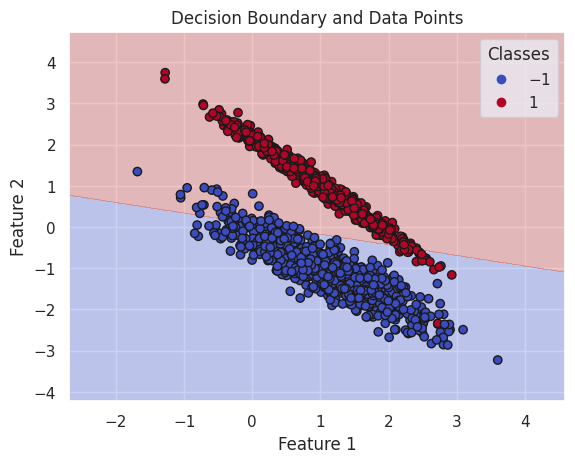

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    plt.plot(model.loss_history)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss History")
    plt.ylim(bottom=0)
    plt.show()

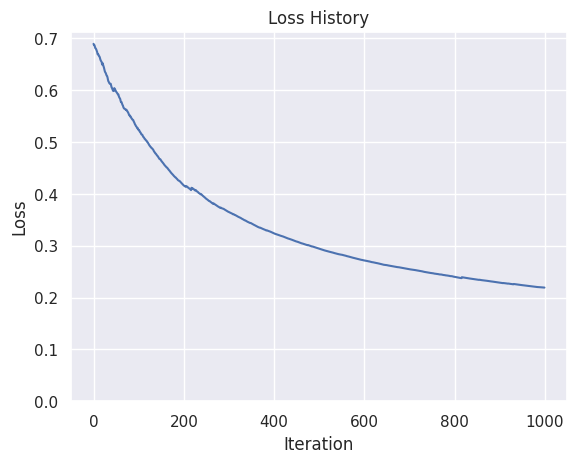

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_values = [0.01, 0.1, 1, 10, 100]

results = []

for kernel in kernels:
    for C in C_values:
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        #метрики
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'AUC-ROC': auc_roc,
            'F1-Score': f1
        })
pd.set_option('display.max_rows', 20)
results_df = pd.DataFrame(results)
print(results_df)

     Kernel       C  Accuracy  Precision    Recall   AUC-ROC  F1-Score
0    linear    0.01  0.997222   0.994286  1.000000  0.999938  0.997135
1    linear    0.10  0.997222   0.994286  1.000000  0.999815  0.997135
2    linear    1.00  0.997222   0.994286  1.000000  0.999351  0.997135
3    linear   10.00  0.997222   0.994286  1.000000  0.998795  0.997135
4    linear  100.00  0.997222   0.994286  1.000000  0.998795  0.997135
5       rbf    0.01  0.994444   1.000000  0.988506  0.999938  0.994220
6       rbf    0.10  0.997222   0.994286  1.000000  1.000000  0.997135
7       rbf    1.00  0.997222   0.994286  1.000000  0.999815  0.997135
8       rbf   10.00  0.997222   0.994286  1.000000  0.996570  0.997135
9       rbf  100.00  0.997222   0.994286  1.000000  0.995056  0.997135
10     poly    0.01  0.997222   0.994286  1.000000  0.996230  0.997135
11     poly    0.10  0.997222   0.994286  1.000000  0.996261  0.997135
12     poly    1.00  0.997222   0.994286  1.000000  0.997683  0.997135
13    

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.base import BaseEstimator, ClassifierMixin #так же можно надеюсь:3

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_indices]
        predictions = np.array([np.bincount(neighbors).argmax() for neighbors in neighbors_labels])
        return predictions

    def predict_proba(self, X):
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_indices]

        proba = np.zeros((X.shape[0], len(np.unique(self.y_train))))
        for i, neighbors in enumerate(neighbors_labels):
            counts = np.bincount(neighbors)
            proba[i, :len(counts)] = counts / self.n_neighbors

        return proba


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Генерация данных
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Создаем и обучаем модель KNN
knn = KNNClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba[:, 1])
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
print(df.head())

   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

In [ ]:
X = df.drop('Category', axis=1)
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50000, random_state=42)
print(X_train.head(), X_test.head(), y_train.head(), y_test.head())


          Id  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
11210  11210         0         0         0         0         0         0   
17024  17024         0         0         0         0         0         0   
43389  43389         0         0         0         0         0         5   
30050  30050         0         0         0         0         0         0   
34665  34665         0         0         0         0         0         0   

       Pixel006  Pixel007  Pixel008  ...  Pixel774  Pixel775  Pixel776  \
11210         0         0         0  ...       135         0         0   
17024         0         0         0  ...         0         0         0   
43389         0         0         0  ...         0         0         0   
30050         0         0         0  ...         0         0         0   
34665         0        59       155  ...         0         0         1   

       Pixel777  Pixel778  Pixel779  Pixel780  Pixel781  Pixel782  Pixel783  
11210         0     

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

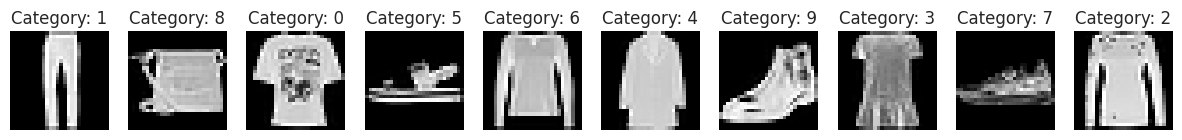

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(X, y):
    unique_categories = y.unique()
    fig, axes = plt.subplots(1, len(unique_categories), figsize=(15, 5))

    for i, category in enumerate(unique_categories):
        class_images = X[y == category]

        if class_images.shape[0] > 0:  # Провверка
            plt.subplot(1, len(unique_categories), i + 1)
            # пропускаем первый столбец
            plt.imshow(class_images.iloc[0, 1:].values.reshape(28, 28), cmap='gray')
            plt.title(f'Category: {category}')
            plt.axis('off')

    plt.show()

plot_samples(X_train, y_train)


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [ ]:
X = df.drop('Category', axis=1)
y = df['Category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50000, random_state=42)

#нормировка с помощью StandardScaler
standard_scaler = StandardScaler()
X_train_standard_scaled = standard_scaler.fit_transform(X_train)
X_test_standard_scaled = standard_scaler.transform(X_test)

#нормировка с помощью MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax_scaled = minmax_scaler.fit_transform(X_train)
X_test_minmax_scaled = minmax_scaler.transform(X_test)

print("Standard Scaler - первые 5 значений обучающей выборки:")
print(X_train_standard_scaled[:5])
print("\nMinMax Scaler - первые 5 значений обучающей выборки:")
print(X_train_minmax_scaled[:5])

Standard Scaler - первые 5 значений обучающей выборки:
[[-1.08347323 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [-0.74771055 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [ 0.77488714 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [ 0.00455031 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [ 0.27106987 -0.00941399 -0.02213614 ...  0.99417792 -0.09175096
  -0.03167199]]

MinMax Scaler - первые 5 значений обучающей выборки:
[[0.18683956 0.         0.         ... 0.         0.         0.        ]
 [0.28374279 0.         0.         ... 0.         0.         0.        ]
 [0.72317411 0.         0.         ... 0.         0.         0.        ]
 [0.50085003 0.         0.         ... 0.         0.         0.        ]
 [0.57776926 0.         0.         ... 0.07843137 0.         0.        ]]


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# Пример: Загрузка данных и разделение на выборки
df = pd.read_csv('/content/drive/MyDrive/train.csv')  # замените на имя вашего файла
X = df.drop('Category', axis=1)
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50000, random_state=42)


KNeighborsClassifier

In [ ]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

knn_best_model = knn_grid_search.best_estimator_
knn_y_pred = knn_best_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
print(f'Лучшие параметры KNN: {knn_grid_search.best_params_}')
print(f'Accuracy KNN: {knn_accuracy}')



KeyboardInterrupt: 

n_neighbors: важно, так как слишком малое значение может привести к переобучению, а слишком большое — к недообучению.
weights: влияет на то, как расстояние до соседей влияет на классификацию.
metric: выбор метрики может существенно изменить результаты классификации, особенно для различных типов данных.


уже два дня торчу на данном этапе, слишком долго. Наверное взял слишком много. Попробую ниже провернуть с одним 'euclidean'

In [ ]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__metric': ['euclidean']
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

knn_best_model = knn_grid_search.best_estimator_
knn_y_pred = knn_best_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
print(f'Лучшие параметры KNN: {knn_grid_search.best_params_}')
print(f'Accuracy KNN: {knn_accuracy}')


Лучшие параметры KNN: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5}
Accuracy KNN: 0.8565


Хоть что-то получилось как я счастлив.:))


LogisticRegression

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Ответ: Модель не сможет выучить разделяющую гиперплоскость. А она важна для разделения классов друг от друга. В итоге модель не сможет найти различия между положительным и отрицательным классом, так как для нее все объекты будут одинаковые.
В конце псевдо-обучения логистическая регрессия сойдется к состоянию, при котором она предсказывает одинаковую вероятность (около 50%) для каждого класса, или будет колебаться вокруг неё. Таким образом, качество модели будет очень низким и близким к случайному угадыванию, так как данные не несут информации для классификации.


#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.